# Задание 2. Стратификация

## Задача

Предположим, что генеральная совокупность - смесь 3-х нормально распределенных с.в., и можем разбить ее на 3 страты. Доли страт в генеральной совокупности разные.

Необходимо сравнить свойства точечных оценок мат. ожидания и дисперсии, полученных на основе выборок с помощью простого случайного выбора из всей генеральной совокупности, пропорционального разбиения на подсэмплы и оптимального разбиения на подсэмплы.

Рассмотреть следующие случаи:

А) все страты имеют одинаковые мат. ожидания и дисперсии

Б) страты имеют разные мат. ожидания, но одинаковые дисперсии

В) страты имеют разные и мат. ожидания, и дисперсии.

Объемы объединенной выборки 40 и 500.

Проверка производится моделированием (1000 повторов).

Доли страт и параметры нормальных распределений выбираете самостоятельно.


## Решение

Подключим необходимые библиотеки

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm

%matplotlib inline

Будем далее рассматривать генеральные совокупности, для которых нормальные распределения смешаны с весами $0.1, 0.3, 0.6$, соответсвенно.

Итак, рассмотрим три генеральные совокупности в соответствии с условием.

А) все страты имеют одинаковые мат. ожидания и дисперсии - пусть это будут три стандартных нормальных распределения $N(0, 1)$;

Б) страты имеют разные мат. ожидания, но одинаковые дисперсии - пусть это будут распределения $N(0, 1)$, $N(10, 1)$, $N(100, 1)$;

В) страты имеют разные и мат. ожидания, и дисперсии - пусть это будут распределения $N(0, 1)$, $N(10, 5)$, $N(100, 10)$.

In [0]:
def stratify_random(weights, exps, stds, total_length):
    '''
    Случайный выбор из генеральной совокупности.
    weights: список весов распределений в смеси,
    exps: математические ожидания распределений,
    stds: стандартные отклонения распределений,
    total_length: суммарный объем выборки
    '''

    num_of_strats = len(weights) # число страт
    sample = np.empty(total_length)
    means = [0] * num_of_strats
    variances = [0] * num_of_strats
    # sample_sizes = [0] * num_of_strats
    
    for i in range(total_length):
        # выбираем номер страты
        strat_ind = np.random.choice(num_of_strats, p=weights)
        # генерируем случайную величину из нужной страты
        sample[i] = norm.rvs(loc=exps[strat_ind], scale=stds[strat_ind], size=1,
                             random_state=None)
        # sample_sizes[i] += 1
        # means[i] += sample[i]
        
    return sample

In [0]:
def stratify_proportional(weights, exps, stds, total_length):
    '''
    Пропорциональное разбиение генеральной совокупности на подсэмплы согласно 
    заданным весам.
    weights: список весов для разбиения,
    exps: математические ожидания распределений,
    stds: стандартные отклонения распределений,
    total_length: суммарный объем выборки
    '''

    num_of_strats = len(weights) # число страт
    sample = np.empty(0)
    means = [None] * num_of_strats
    variances = [None] * num_of_strats
    
    for i in range(num_of_strats):
        # находим число элементов, соответствующих текущей страте
        if i == num_of_strats - 1:
            length = total_length - len(sample)
        else:
            length = int(round(weights[i] * total_length))
        # генерируем элементы из нужной страты
        strat_sample = norm.rvs(loc=exps[i], scale=stds[i], size=length,
                                random_state=None)
        # вычисляем выборочные среднее и дисперсию для данной страты
        means[i] = strat_sample.mean()
        variances[i] = strat_sample.var()
        # склеиваем страты друг с другом
        sample = np.concatenate((sample, strat_sample), axis=0)
        
    return sample, means, variances

In [0]:
def stratification(weights, exps, stds, total_length, mode='random'):
    '''
    weights: список весов распределений в смеси,
    exps: математические ожидания распределений,
    stds: стандартные отклонения распределений,
    total_length: суммарный объем выборки
    mode: 'random' (простой случайный выбор), 'proportional' (пропорциональное
    разбиение на подсэмплы) или 'optimal' (оптимальное разбиение на подсэмплы)
    '''

    assert len(weights) == len(exps) == len(stds)
    assert sum(weights) == 1
    assert (std > 0 for std in stds)

    if mode == 'random': # простой случайный выбор
        return stratify_random(weights, exps, stds, total_length)
    elif mode == 'proportional': # пропорциональное разбиение на подсэмплы
        return stratify_proportional(weights, exps, stds, total_length)
    elif mode == 'optimal': # оптимальное разбиение на подсэмплы
        # пересчитываем веса, с которыми каждая страта будет входить в 
        # оптимальное разбиение
        optimal_weights = np.array(weights) * np.array(stds)
        total_sum = sum(optimal_weights)
        optimal_weights = optimal_weights / total_sum
        # разбиваем генеральную совокупность в соответствии с этими весами
        return stratify_proportional(optimal_weights, exps, stds, total_length)

Сгенерируем теперь по 1000 выборок для каждого из случаев А), Б), В), каждого способа разбиения и двух вариантов размера выборки (40 и 500). Для каждой выборки вычислим оценки мат. ожидания и дисперсии. Тем самым получим 18 выборок для мат. ожидания и столько же - для дисперсии.

Итак, зададим начальные данные.

In [0]:
# веса распределений в смеси
weights = [0.1, 0.3, 0.6]

# случай А)
exps_a = [0, 0, 0]
stds_a = [1, 1, 1]

# случай Б)
exps_b = [0, 10, 100]
stds_b = [1, 1, 1]

# случай В)
exps_c = [0, 10, 100]
stds_c = [1, 5, 10]

# размеры выборок
sample_sizes = [40, 500]

# число выборок
num_of_experiments = 1000

# число режимов генерации выборки
modes = ['random', 'proportional', 'optimal']
num_of_modes = len(modes)

In [0]:
def run_experiments(weights, exps, stds, sample_sizes, num_of_experiments):    
    '''
    Запускаем эксперимент для разных размеров выборок, разных способов 
    стратификации, сравниваем результаты.
    weights: список весов распределений в смеси,
    exps: математические ожидания распределений,
    stds: стандартные отклонения распределений,
    sample_sizes: список с размерами смешанной выборки для эксперимента
    num_of_experiments: количество экспериментов
    '''

    for sample_size in sample_sizes:
        means = np.empty((num_of_modes, num_of_experiments))
        variances = np.empty((num_of_modes, num_of_experiments))
        for mode_ind, mode in enumerate(modes):
            for experiment in range(num_of_experiments):
                sample = stratification(weights, exps, stds, sample_size, mode)
                means[mode_ind, experiment] = sample.mean()
                variances[mode_ind, experiment] = sample.var()
        plt.boxplot([means[i] for i in range(num_of_modes)], labels=modes)
        plt.title(f'Means, sample_size = {sample_size}')
        plt.show()
        plt.boxplot([variances[i] for i in range(num_of_modes)], labels=modes)
        plt.title(f'Variances, sample_size = {sample_size}')
        plt.show()

### Случай А): одинаковые мат. ожидания и дисперсии

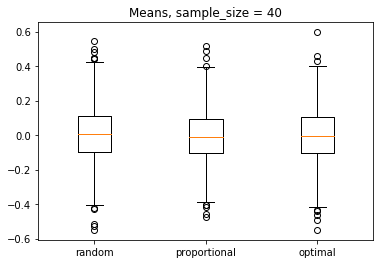

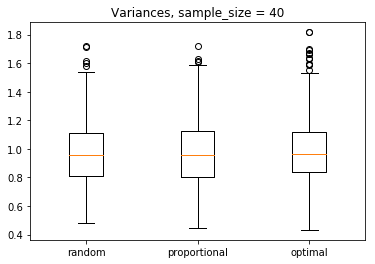

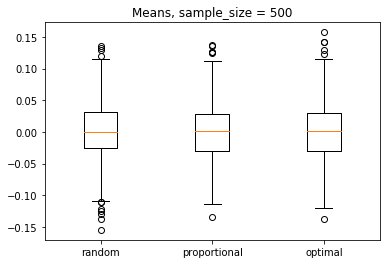

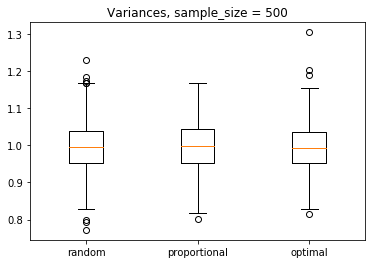

In [0]:
run_experiments(weights, exps_a, stds_a, sample_sizes, num_of_experiments)

Как нетрудно заметить, здесь все три способа сэмплирования показывают примерно одинаковые результаты. Это вполне логично, ведь по сути распределение результирующей выборки не является смесью, и для всех способов сэмплирования будет получаться выборка из того же самого первоначального распределения.

### Случай Б): разные мат. ожидания, одинаковые дисперсии

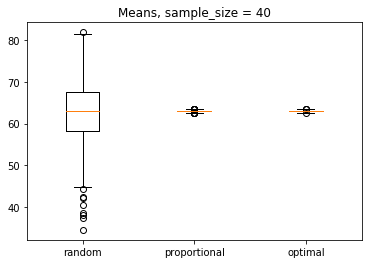

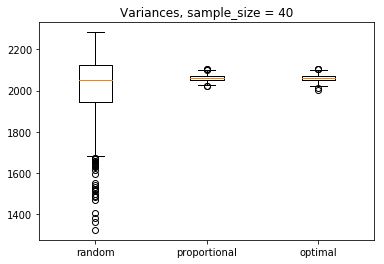

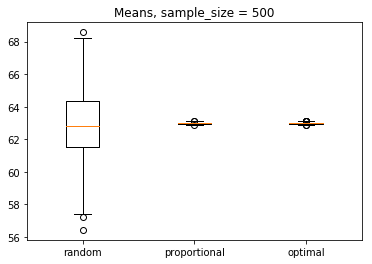

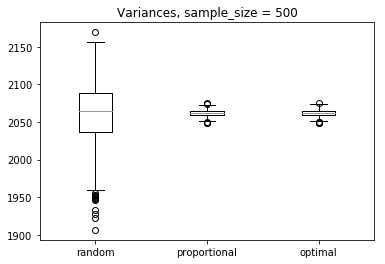

In [0]:
run_experiments(weights, exps_b, stds_b, sample_sizes, num_of_experiments)

В этом случае математические ожидания смеси при разных способах сэмплирования имеют довольно близкие средние значения, однако наблюдается существенная разница в дисперсиях для мат. ожиданий смеси. Дисперсии смеси тоже располагаются вокруг одного значения, однако пропорциональный и оптимальный способы сэмплирования дают намного меньший разброс этих дисперсий, чем простой случайный выбор.

### Случай В): разные мат. ожидания и дисперсии

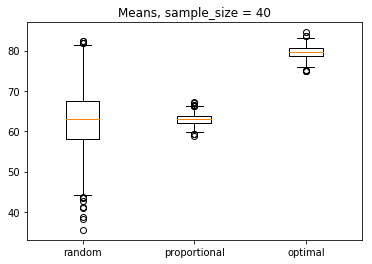

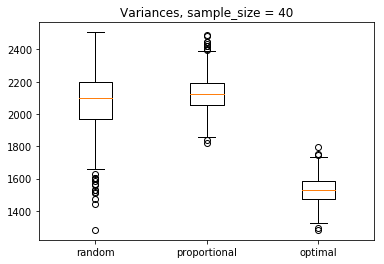

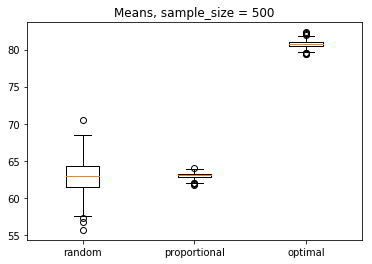

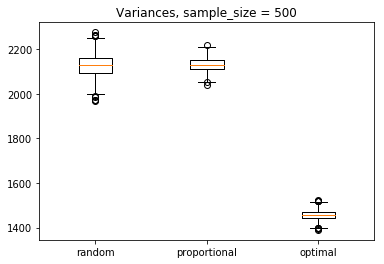

In [0]:
run_experiments(weights, exps_c, stds_c, sample_sizes, num_of_experiments)

Здесь, как и в прошлый раз, можно заметить гораздо больший разброс как мат. ожиданий, так и дисперсий у простого случайного выбора по сравнению с другими способами сэмплирования. 

Несколько странным на первый взгляд кажется то, что мат. ожидание при оптимальном сэмплировании оказывается больше, чем при других способах. Но на самом деле, этот результат подтверждается формулами и для заданных значений параметров является верным.

Действительно, мат. ожидания средних при простом случайном выборе и при пропорциональном сэмплировании совпадают (это нетрудно показать). Как в случае пропорционального сэмплирования, так и при оптимальном сэмплировании мат. ожидание средних значений смеси представляет из себя взвешенную сумму средних. Однако веса для этих двух способов сэмплирования отличаются. Для выбранных значений параметров веса для пропорционального выбора составляют заданные изначально $w_1=0.1, w_2=0.3, w_3=0.6$ в то время, как для оптимального выбора они будут равны $w_1=\frac{0.1\cdot 1}{0.1\cdot 1 + 0.3\cdot 5 + 0.6\cdot 10} = \frac{1}{76}, w_2=\frac{15}{76}, w_3=\frac{60}{76}$. Поэтому мат. ожидание средних будет смещено в нашем случае в сторону мат. ожидания третьей страты.